# Imports and helper functions

In [16]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM
import numpy as np
from pandas import Series, read_csv, DataFrame
import pandas as pd
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from seaborn import heatmap
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima

ANOMALY_RATIO = 0.02

# Task 3.1 - Anomaly detection for uni-variate series with ARIMA

**Read and parse the data**

In [3]:
data = read_csv('TemperatureAnomalies.csv')
series = Series(data['temperature change'].values, index=data['year'].values)

**Plot the data in various ways**

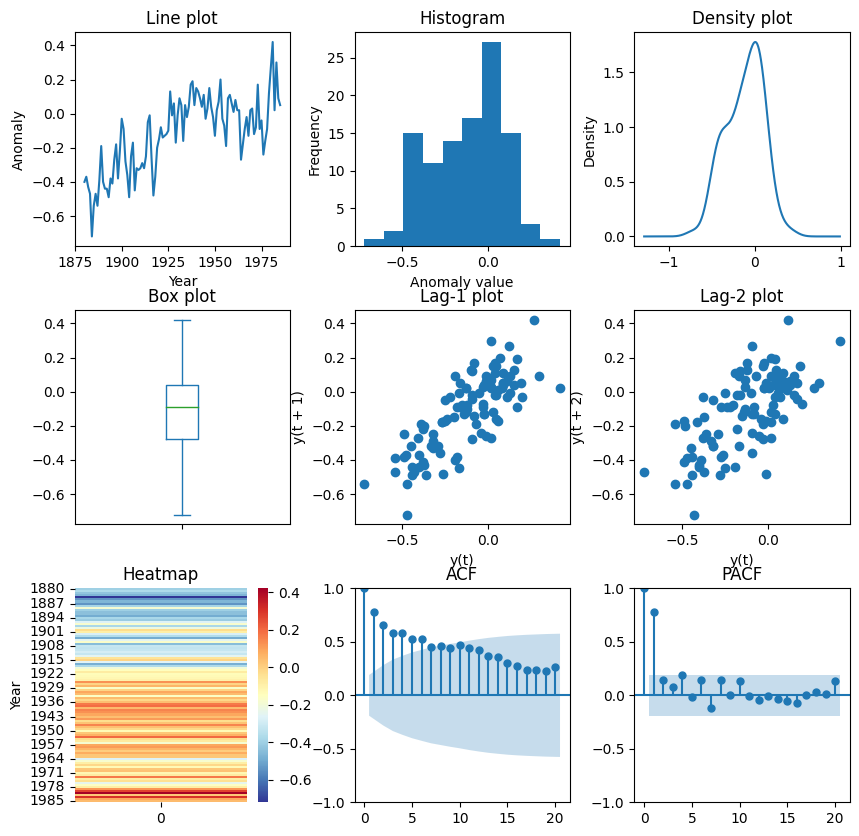

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

series.plot(ax=axes[0, 0], kind='line', title='Line plot', xlabel='Year', ylabel='Anomaly')
series.plot(ax=axes[0, 1], kind='hist', title='Histogram', xlabel='Anomaly value', ylabel='Frequency')
series.plot(ax=axes[0, 2], kind='density', title='Density plot', xlabel='??', ylabel='Density')
series.plot(ax=axes[1, 0], kind='box', title='Box plot')
lag_plot(series, ax=axes[1, 1], lag=1)
axes[1, 1].set_title('Lag-1 plot')
lag_plot(series, ax=axes[1, 2], lag=2)
axes[1, 2].set_title('Lag-2 plot')
plot_acf(series.values.reshape(-1, 1), ax=axes[2, 1], lags=20, title='ACF')
plot_pacf(series, ax=axes[2, 2], lags=20, title='PACF')
heatmap(DataFrame(series), cmap='RdYlBu_r', ax=axes[2, 0])
axes[2, 0].set_title('Heatmap')
axes[2, 0].set_ylabel('Year')
axes[2, 0].set_xlabel('')

fig.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()